## PURPOSE OF THIS NOTEBOOK

The goal here is to test code and functions that will be used to automate the finding of key corners. 

In [47]:
import pandas as pd
import numpy as np
import fastf1
import fastf1.plotting
import matplotlib as mpl
import datetime
import timedelta

from scipy import stats
from scipy.signal import find_peaks
from sklearn.preprocessing import normalize
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection

## Starting off 
I'm going to start off by doing a 1 lap experiement on testing code that points out which corners are key to analyizing driver braking confidence. Part of this will be filtering and ranking each of the predefined zones and only analyzing the most important zones. 

In [48]:
# Get lap information
race = fastf1.get_session(2025, 4, 'R')
race.load()

core           INFO 	Loading data for Bahrain Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	Driver 63: Lap timing integrity check failed for 3 lap(s)
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['81', '63', '4', '16', '44', '1', '10', '31', '22', '87', '12', '23', '6', '7', '14', '30', '18', '

In [49]:
# Going to evaluate only the fastest lap as an example, will add other drivers soon 
fastest_lap = race.laps.pick_fastest()
car_data = fastest_lap.get_telemetry().add_distance()
lap_tel = car_data.copy()

In [50]:
# Now Calculate the brakezones 
lap_tel['BrakeZone'] = lap_tel[lap_tel['Brake']].index.to_series().diff().ne(1).cumsum()

visualize = lap_tel.copy()
# Drop rows where brake zone is NaN
lap_tel = lap_tel.dropna(subset=['BrakeZone'])

In [51]:
# Now Calculate other features such as Decleration
lap_tel['DistanceBraked'] = lap_tel.groupby('BrakeZone')['Distance'].diff().fillna(0)
lap_tel['TotalDistanceBraked'] = lap_tel.groupby('BrakeZone')['DistanceBraked'].transform('sum')
# Now Calculate Average Speed at braking
lap_tel['AvgSpeedBraking'] = lap_tel.groupby('BrakeZone')['Speed'].transform('mean')
# Calculate braking times and total laptime in seconds
lap_tel['TotalTime'] = lap_tel['Time'].iloc[-1].total_seconds()
brake_start_dict = {}
brake_end_dict = {}
brake_start_speed_dict = {}
brake_end_speed_dict = {}
for zone, group in lap_tel.groupby('BrakeZone'):
    brake_start_dict[zone] = group['Time'].min().total_seconds()
    brake_end_dict[zone] = group['Time'].max().total_seconds()
    brake_start_speed_dict[zone] = group['Speed'].max()
    brake_end_speed_dict[zone] = group['Speed'].min()

# Map each new value 
lap_tel['SpeedatBrakeStart'] = lap_tel['BrakeZone'].map(brake_start_speed_dict)
lap_tel['SpeedatBrakeEnd'] = lap_tel['BrakeZone'].map(brake_end_speed_dict)
lap_tel['BrakeStartTime'] = lap_tel['BrakeZone'].map(brake_start_dict)
lap_tel['BrakeEndTime'] = lap_tel['BrakeZone'].map(brake_end_dict)
lap_tel['TimeBraking'] = lap_tel['BrakeEndTime'] - lap_tel['BrakeStartTime']

# Convert from kph to m/s
lap_tel['SpeedatBrakeStartMS'] = lap_tel['SpeedatBrakeStart'] * .2778
lap_tel['SpeedatBrakeEndMS'] = lap_tel['SpeedatBrakeEnd'] * .2778

# Calculate Deceleration
lap_tel['Deceleration'] = (lap_tel['SpeedatBrakeStartMS']) / lap_tel['TimeBraking']

/tmp/ipykernel_272437/2429687791.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lap_tel['DistanceBraked'] = lap_tel.groupby('BrakeZone')['Distance'].diff().fillna(0)
/tmp/ipykernel_272437/2429687791.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lap_tel['TotalDistanceBraked'] = lap_tel.groupby('BrakeZone')['DistanceBraked'].transform('sum')
/tmp/ipykernel_272437/2429687791.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

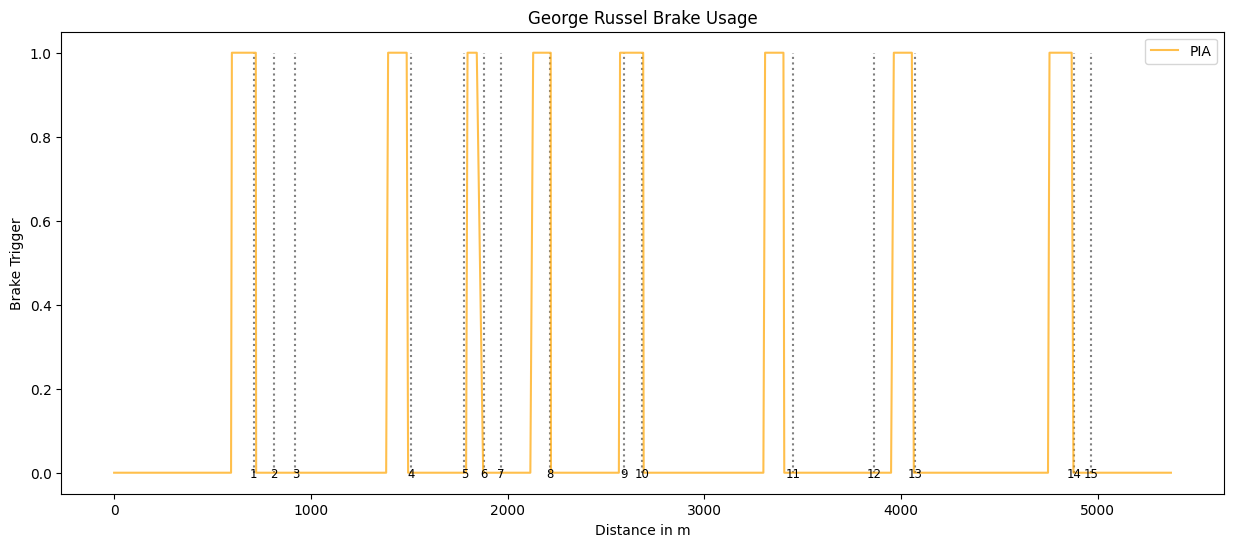

In [53]:
# Visualize key aspects
circuit_info = race.get_circuit_info()

# Plot Binary plot showing braking over distance 
fig, ax = plt.subplots() 

fig.set_figheight(6)
fig.set_figwidth(15)

ax.vlines(x=circuit_info.corners['Distance'], ymin=0, ymax=1, linestyles="dotted", colors='grey')

# Plot corners 
for _, corner in circuit_info.corners.iterrows():
    txt = f"{corner['Number']}{corner['Letter']}"
    ax.text(corner['Distance'], 0, txt, 
            va='center_baseline', ha='center', size='small')
    
ax.plot(visualize['Distance'], visualize['Brake'], label ='PIA', color="orange", alpha=0.7)
ax.set_xlabel('Distance in m')
ax.set_ylabel('Brake Trigger')
ax.set_title("George Russel Brake Usage")
ax.legend()

plt.show()

In [24]:
# Now let's analyze braking zones 
def analyze_braking_zones(lap_tel):
    # Group by zones 
    grouped = lap_tel.groupby('BrakeZone')

    # Calculate summary statistics for deceleration 
    zone_stats = grouped['Deceleration'].agg(['mean', 'max', 'std', 'count'])
    zone_stats['ZoneLength'] = grouped['Distance'].max() - grouped['Distance'].min()
    zone_stats['ZoneStart'] = grouped['Distance'].min() 
    
    return zone_stats

In [42]:
def filter_and_rank_zones(zone_stats, min_zone_length=5, min_mean_deceleration=1, num_zones=3):
    # Filter out short or weak zones 
    filtered_zones = zone_stats[
        (zone_stats['ZoneLength'] > min_zone_length) &
        (zone_stats['mean'] > min_mean_deceleration)
    ].copy()

    # Calculate a braking intestity score
    filtered_zones['BrakingIntensity'] = filtered_zones['mean'] * filtered_zones['ZoneLength']

    # Rank the zones 
    ranked_zones = filtered_zones.sort_values(by='BrakingIntensity', ascending=False)

    top_zones = ranked_zones.head(num_zones)

    return top_zones

In [43]:
zone_stats = analyze_braking_zones(lap_tel).reset_index()
ranked_zones = filter_and_rank_zones(zone_stats).reset_index(drop=True)

In [44]:
ranked_zones

,BrakeZone,mean,max,std,count,ZoneLength,ZoneStart,BrakingIntensity
0,8.0,38.385470,38.385470,0.0,17,112.569431,4754.550899,4321.030542
1,6.0,44.390722,44.390722,0.0,14,93.245801,3308.921533,4139.248401
2,2.0,38.400925,38.400925,0.0,16,94.380194,1392.714021,3624.286737


## Checkpoint
I have now ranked zones based on importance. From my knowledge, these braking zones make sense on why they are considered important. I visualized where braking zones are in relation to corners and know the most important are the turn 4, turn 11, and turn 14. Which is true, these corners are where passing is the most common for drivers as well as the hardest braking zones for Bahrain. Now instead of doing 1 lap, I will do the entire race for Piastri 

In [54]:
# Now get all laps for Oscar
race_laps = race.laps

# Filter to the drivers we want to compare 
PIA_lap = race.laps.pick_drivers('PIA').pick_accurate()